In [177]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras
#%matplotlib widget
#import ipywidgets as widgets
#import ipympl
plt.style.use('ggplot')

In [2]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )
    
    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = '/Users/rohittikle/Downloads/A3P2/criteo_attribution_dataset/criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 20

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])


114517
[57511, 57006]


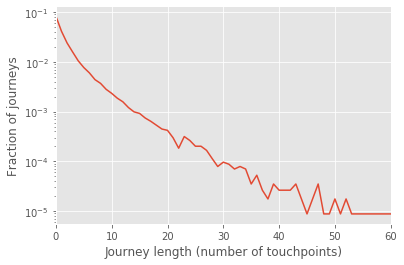

In [15]:
# Data exploration

def journey_lenght_histogram(df):
    counts = df.groupby(['jid'])['uid'].count().reset_index(name="count").groupby(['count']).count()
    return counts.index, counts.values / df.shape[0]

hist_x, hist_y = journey_lenght_histogram(df4)

plt.plot(range(len(hist_x)), hist_y, label='all journeys')
plt.yscale('log')
plt.xlim(0, 60)
plt.xlabel('Journey length (number of touchpoints)')
plt.ylabel('Fraction of journeys')
plt.show()

In [64]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)



In [132]:
def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
campaign_impressions = count_by_campaign(df6)
campaign_impressions
    

array([40218., 34969.,  3425.,  2938.,  9051.,  2956.,  2136.,  9487.,
         996.,   535.,  1649.,  1579.,   286.,   392.,   492.,  1953.,
         484.,   420.,   413.,   138.])

In [118]:
def last_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(max) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
lta = last_touch_attribution(df6)


array([0.11101994, 0.20827018, 0.02043796, 0.02893125, 0.06264501,
       0.11366712, 0.0744382 , 0.13808369, 0.04819277, 0.16074766,
       0.05579139, 0.04623179, 0.09440559, 0.06632653, 0.04065041,
       0.10957501, 0.17355372, 0.02857143, 0.07021792, 0.05797101])

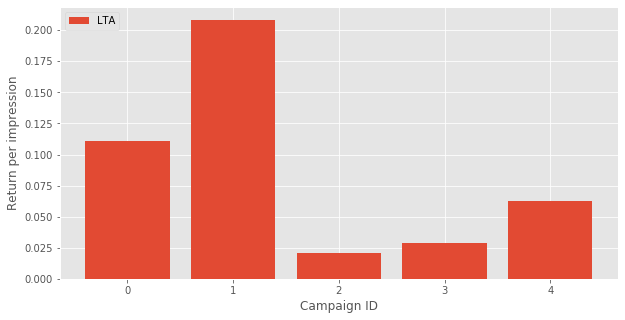

In [186]:
# Visualization of the attribution scores

campaign_idx = range(0, 5)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.bar( range(len(lta[campaign_idx])), lta[campaign_idx], label='LTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [178]:
#First Touch Attribution

def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['jid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)


/Users/rohittikle/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


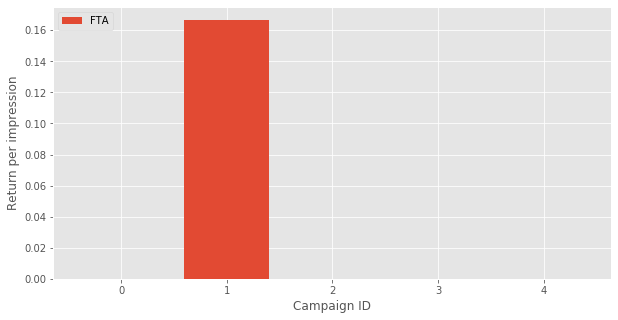

In [185]:
# Visualization of the attribution scores

campaign_idx = range(0, 5)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [30]:
# Logistic regression
def features_for_logistic_regression(df):

    def pairwise_max(series):
        return np.max(series.tolist(), axis = 0).tolist()
    
    aggregation = {
        'campaigns': pairwise_max,
        'cats': pairwise_max,
        'click': 'sum',
        'cost': 'sum',
        'conversion': 'max'
    }
    
    df_agg = df.groupby(['jid']).agg(aggregation)
    
    df_agg['features'] = df_agg[['campaigns', 'cats', 'click', 'cost']].values.tolist()
    
    return (
        np.stack(df_agg['features'].map(lambda x: np.hstack(x)).values),
        df_agg['conversion'].values
    )

In [31]:
x, y = features_for_logistic_regression(df6)
print(np.shape(x))

(24408, 185)


In [32]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 1)

In [33]:
# Quick sanity check
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print(score)

/Users/rohittikle/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8158541581319132


In [34]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout
from keras.constraints import NonNeg

m = np.shape(x)[1]
    
model = Sequential()  
model.add(Dense(1, input_dim=m, activation='sigmoid', name = 'contributions')) 

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy']) 
history = model.fit(x_train, y_train, batch_size=128, epochs=10, verbose=1, validation_data=(x_val, y_val)) 
score = model.evaluate(x_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Train on 15620 samples, validate on 3906 samples
Epoch 1/10
15620/15620 [==============================] - 0s 27us/step - loss: 0.6063 - accuracy: 0.7025 - val_loss: 0.5588 - val_accuracy: 0.7506
Epoch 2/10
15620/15620 [==============================] - 0s 10us/step - loss: 0.5433 - accuracy: 0.7593 - val_loss: 0.5192 - val_accuracy: 0.7721
Epoch 3/10
15620/15620 [==============================] - 0s 10us/step - loss: 0.5166 - accuracy: 0.7750 - val_loss: 0.4991 - val_accuracy: 0.7821
Epoch 4/10
15620/15620 [==============================] - 0s 9us/step - loss: 0.5017 - accuracy: 0.7825 - val_loss: 0.4866 - val_accuracy: 0.7878
Epoch 5/10
15620/15620 [==============================] - 0s 9us/step - loss: 0.4916 - accuracy: 0.7860 - val_loss: 0.4775 - val_accuracy: 0.7934
Epoch 6/10
15620/15620 [==============================] - 0s 9us/step - loss: 0.4841 - accuracy: 0.7892 - val_loss: 0.4704 - val_accuracy: 0.7970
Epoch 7/10
15620/15620 [==============================] - 0s 9us/step - 

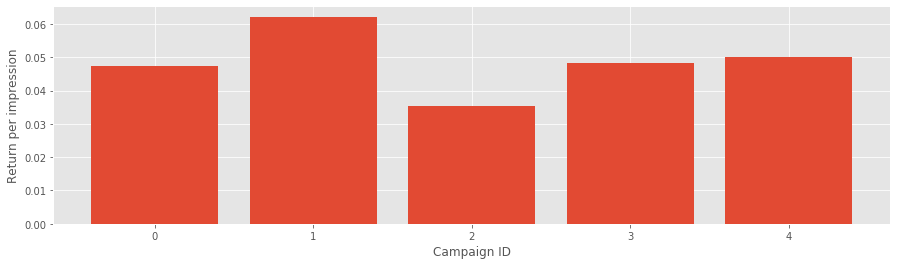

In [35]:
# Visualization of the attribution scores
from sklearn.utils.extmath import softmax

keras_logreg = model.get_layer('contributions').get_weights()[0].flatten()[0:n_campaigns]
keras_logreg = softmax([keras_logreg]).flatten()

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(keras_logreg[campaign_idx])), keras_logreg[campaign_idx] )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.show()

In [166]:
## U-Shaped

df6 =df6.head(50)
#df6 = df6.groupby[df6['jid'],df6['campaign']]
#df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm']) 

def u_shaped(df):
    df7 = df6.groupby(['campaign', 'jid']) 
    df7.head()


    df9 = pd.DataFrame()
    for key, item in df7:
        #print('new_group')
        df8 = df7.get_group(key).reset_index()
        #print(df8)
        df8['weight'] = 1

        n=len(df8)
    
#     df8['weight'].iloc[[0,-1]]=1
        i = 0
        for i in range(1,n):
            if i == 0 or i == n-1:
                df8.loc[i,'weight']=1
            else:
                df8.loc[i,'weight'] = 1/(n-1)
        
    #print(len(df7.get_group(key)), "\n\n")
    #print('assign weights')
        df9 = df9.append(df8)
    return df9
    
df10 = u_shaped(df6)
df10

,index,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,...,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,weight
0,17848,277,31203722,5061823,0,-1,-1,0,0,-1,...,27093701,7477605,29196072,8661620,31203722_-1,0.000104,3.345458e-01,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
0,68625,106,467359,12351511,0,-1,-1,0,0,-1,...,3808271,9312274,29196072,29196072,467359_-1,0.000040,0.000000e+00,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
0,45427,74,18913468,13661597,0,-1,-1,0,1,-1,...,5824235,18000586,29196072,8661623,18913468_-1,0.000028,2.745084e-01,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
0,101148,501,5136543,13661597,0,-1,-1,0,0,-1,...,1973606,529540,32440044,29196072,5136543_-1,0.000188,0.000000e+00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
0,23661,316,14571825,13661605,0,-1,-1,0,0,-1,...,1973606,23102667,32440044,29196072,14571825_-1,0.000118,0.000000e+00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
0,16212,655,24650385,13661605,0,-1,-1,0,0,-1,...,28928366,23572587,29196072,8661620,24650385_-1,0.000245,3.014582e-01,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
1,62301,683,24650385,13661605,0,-1,-1,0,0,-1,...,28928366,23572587,29196072,8661620,24650385_-1,0.000256,3.014690e-01,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
0,23426,317,25829161,13661605,0,-1,-1,0,1,-1,...,29196072,13591581,29196072,29196072,25829161_-1,0.000119,0.000000e+00,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
0,47577,41,83645,13661605,0,-1,-1,0,0,-1,...,1973606,22203375,32440044,29196072,83645_-1,0.000015,0.000000e+00,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
1,89484,384,83645,13661605,0,-1,-1,0,0,-1,...,1973606,22203375,29196072,29196072,83645_-1,0.000144,0.000000e+00,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0


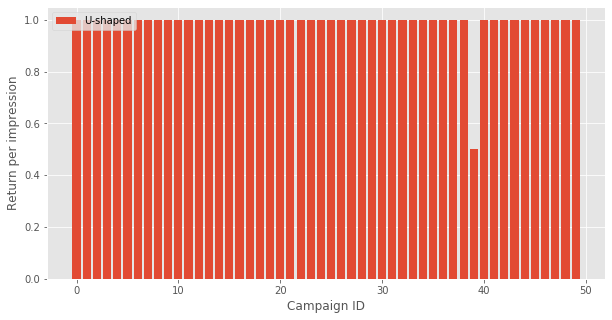

In [174]:
# Visualization of the attribution scores# U-shaped

#campaign_idx = range(15, 20)

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)

plt.bar( range(len(df10['campaign'])), df10['weight'], label='U-shaped' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

In [164]:
##Linear

def linear(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    campaign_count = df_converted.groupby('jid')['campaign'].transform('count') #gives count of campaigns in one journey id
    
    return df['campaign'],1/campaign_count
df6=df6.head(500)
campaign_id, campaign_count = linear(df6)

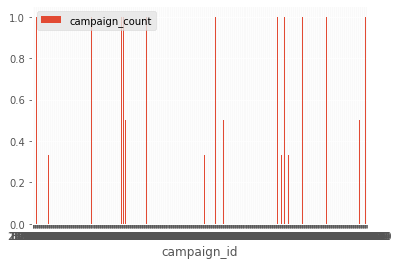

In [165]:
lin = pd.DataFrame()
lin['campaign_id'] = campaign_id
lin['campaign_count'] = campaign_count
lin.plot.bar(x='campaign_id', y='campaign_count', rot=0)

In [199]:
# SIMULATION
# Key assumption: If one of the campaigns in a journey runs out of budget, 
# then the conversion reward is fully lost for the entire journey
# including both past and future campaigns

def simulate_budget_roi(df, budget_total, attribution, verbose=False):
    budgets = np.ceil(attribution * (budget_total / np.sum(attribution)))
    
    if(verbose):
        print(budgets)
    
    blacklist = set()
    conversions = set()
    for i in range(df.shape[0]):
        campaign_id = get_campaign_id(df.loc[i]['campaigns']) 
        jid = df.loc[i]['jid']
        if jid not in blacklist:
            if budgets[campaign_id] >= 1:
                budgets[campaign_id] = budgets[campaign_id] - 1
                if(df.loc[i]['conversion'] == 1):
                    conversions.add(jid)
            else:
                blacklist.add(jid)
        
        if(verbose):
            if(i % 10000 == 0):
                print('{:.2%} : {:.2%} budget spent'.format(i/df.shape[0], 1.0 - np.sum(budgets)/budget_total ))
        
        if(np.sum(budgets) < budget_total * 0.02):
            break
            
    return len(conversions.difference(blacklist))

In [211]:
pitches = [0.1, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
attributions = [lta, keras_logreg, lstm_a]

for i, pitch in enumerate(pitches):
    for j, attribution in enumerate(attributions):
        reward = simulate_budget_roi(df6, 10000, attribution**pitch)
        print('{} {} : {}'.format(i, j, reward))

KeyError: 0